In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.io import excel

# Preparation of the transport network.
## Saves PT networks with clustered nodes.
## Needs PT networks.

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

In [31]:
sm = stepmodel.read_json(input_path + 'de_pt_network')

In [32]:
# Make sure to use the right zones
try:
    z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path + 'base' + '/' + 'de_zones')
#z.zones['FID'] = z.zones['NUTS_ID']
sm.zones = gpd.GeoDataFrame(z.zones)
bus.zones = gpd.GeoDataFrame(z.zones)

In [8]:
# Add reactivate links and nodes to the network, if policy is set
reasons = params['network_reactivation']['inclusion_reasons']
if isinstance(reasons, str):
    # Load rail network reactivation links and nodes
    reac_links = gpd.read_file(input_path + '/de_rail_reactivation/links.geojson')
    reac_nodes = gpd.read_file(input_path + '/de_rail_reactivation/nodes.geojson')
    
    # Adjust format to sm.links
    reac_links.drop('index', axis=1, inplace=True)
    reac_links.index = ['rs_reac_'+str(i) for i in range(len(reac_links))]
    nodes_new_index = ['rs_reac_'+str(i) for i in range(len(reac_nodes))]
    node_dict = dict(zip(reac_nodes['index'], nodes_new_index))
    reac_links['a'] = reac_links['a'].map(node_dict)
    reac_links['b'] = reac_links['b'].map(node_dict)
    reac_nodes.index = nodes_new_index
    reac_nodes['route_type'] = 'rail_short'
    reac_links['route_id'] = reac_links['trip_id']
    
    # Commpute headways from scenario settings
    reac_nodes['urbanisation'] = np.nan
    for u in sm.zones['urbanisation'].unique():
        reac_nodes.loc[reac_nodes['geometry'].within(
            sm.zones.loc[sm.zones['urbanisation']==u, 'geometry'].unary_union
        ), 'urbanisation'] = u
    reac_nodes.loc[reac_nodes['urbanisation'].isna(), 'urbanisation'] = 3
    reac_links['urbanisation'] = reac_links['a'].map(reac_nodes['urbanisation']).astype(int)
    reac_links['headway'] = np.nan
    for u in sm.zones['urbanisation'].unique():
        reac_links.loc[reac_links['urbanisation']==u, 'headway'] = params['max_headway_urban'+str(u)]['rail_short']

    # Filter for reasons
    reasons = [s.strip() for s in reasons.split(';')]
    if reasons == list('ABCDEFGHI'):
        filtered_links = reac_links
        filtered_nodes = reac_nodes
    else:
        filtered_links = reac_links.loc[reac_links['agency_id'].apply(
            lambda s: len( set(s.split(';')).intersection(set(reasons)) ) > 0)]
        filtered_nodes = reac_nodes.loc[list(set(list(filtered_links['a']) + list(filtered_links['b'])))]
    sm.links = pd.concat([sm.links, filtered_links])[list(sm.links.columns)]
    sm.nodes = pd.concat([sm.nodes, filtered_nodes])[list(sm.nodes.columns)]
    print('Added {} rail short links due to reactivation'.format(len(filtered_links)))

## Test links and nodes for network integrity
Neccessary for any further steps

In [33]:
# FIRST: Set time of free-rider links
# Default velocity of 14 m/s for rail links
sm.links.loc[sm.links['time']==0, 'time'] = (sm.links.loc[
    sm.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 14).astype(int)
# 8 m/s for bus links
bus.links.loc[bus.links['time']==0, 'time'] = (bus.links.loc[
    bus.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 8).astype(int)

In [34]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

no road_links or road_nodes


In [11]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [12]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    if len(trip) > 1:
        trip = trip.sort_values('link_sequence')
        # Check link succession
        ind = list(trip.index)
        for i in range(len(trip.index) - 1):
            try:
                assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                    'broken trip {}: stop {} has no successor link'.format(
                        trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
            except AssertionError:
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                    trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
        # Repair sequences
        if len(trip) != trip['link_sequence'].max():
            trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
                lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [13]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [35]:
try:
    sm.links.groupby('trip_id').apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').apply(test_sequences)
    sm.links = links

In [15]:
broken_seqs = bus.links.groupby('trip_id').apply(test_sequences_save)
if not broken_seqs is None:
    links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                         ].groupby('trip_id').apply(fix_sequences)
    links.reset_index(level=0, drop=True, inplace=True)
    links.groupby('trip_id').apply(test_sequences)
    bus.links = pd.concat([bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()), links])

In [16]:
assert len(bus.nodes['route_type'].unique()) == 1

In [17]:
sm.links.sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,headway,geometry
index,,,,,,,,,
rs_45434,rs_34,rail_short,rs_n_1713,rs_n_9544,120,rs_34_3,3,21600,"LINESTRING (8.37375 49.20834, 8.36027 49.19498)"


In [36]:
sm.nodes.sample()

,stop_name,route_type,geometry
index,,,
rs_n_6135,Treuchtlingen,rail_short,POINT (10.90816 48.96127)


## Cluster nodes

Apply agglomerative clustering by zone with mode-specific distance thresholds. They determine the radius of any node cluster.

In [37]:
# Merge bus with other PT
sm.links = pd.concat([sm.links, bus.links])
sm.nodes = pd.concat([sm.nodes, bus.nodes])

In [38]:
sm.links.shape

(2171507, 9)

In [21]:
sm.nodes.shape

(410735, 3)

In [39]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [40]:
# Convert the coordinate system to metric, cartesian
# for the clustering algorithm to work
sm = sm.change_epsg(3857, 'meter')

Reprojecting model from epsg 4326 to epsg 3857:   0%|                                           | 0/15 [00:00<?, ?it/s]C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 15/15 [00:08<00:00,  1.76it/s]


In [41]:
# Cluster agglomeratively (with a cluster radius)
# by route_type and zone
nodes = []
all_nodes = gpd.GeoDataFrame(sm.nodes.copy())
links = []
all_links = gpd.GeoDataFrame(sm.links.copy())
sm.clustering_zones = sm.zones.copy()
# Process each mode seperately and concatenate tables in the end
for mode in sm.nodes['route_type'].unique():
    print(mode + '...')
    sm.nodes = all_nodes.loc[all_nodes['route_type']==mode]
    sm.links = all_links.loc[all_links['route_type']==mode]
    nodes_index = list(sm.nodes.index)
    dist_col = 'radius_'+mode
    sm.clustering_zones[dist_col] = params['clustering'][dist_col]
    
    if sm.clustering_zones[dist_col].mean() != 0:
        sm.preparation_clusterize_nodes(adaptive_clustering=True, distance_col=dist_col)
        # Reindex with mode names
        prefix = ''.join([s[0] for s in mode.split('_')]) + '_'
        sm.nodes.index = [prefix + str(i) for i in sm.nodes.index]
        sm.links['a'] = prefix + sm.links['a'].apply(str)
        sm.links['b'] = prefix + sm.links['b'].apply(str)
        # Set route_type
        sm.nodes['route_type'] = mode
        
    nodes.append(sm.nodes.copy())
    links.append(sm.links.copy())
    
sm.nodes = pd.concat(nodes)
sm.links = pd.concat(links)

Mean distance threshold is 500


C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Mean distance threshold is 500


C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Mean distance threshold is 5000


C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Mean distance threshold is 1200


C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [44]:
# Convert the coordinate system back
sm = sm.change_epsg(4326, 'degree')

Reprojecting model from epsg 3857 to epsg 4326:   0%|                                           | 0/19 [00:00<?, ?it/s]C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
Reprojecting model from epsg 3857 to epsg 4326: 100%|██████████████████████████████████| 19/19 [00:10<00:00,  1.75it/s]


In [42]:
sm.nodes.sample()

,geometry,route_type,stop_name
b_55660080_3,POINT (843441.2802483334 6832516.6424782),bus,NaN


In [43]:
len(sm.nodes)

126997

In [48]:
# Average number of stops per cluster
sm.node_clusters['count'].mean()

3.3102494925787025

## Clean
And map nodes to zones

In [50]:
# Map nodes to zones
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
sm.nodes['FID'] = np.nan
for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
    sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry'].buffer(1e-3)), 'FID'] = zone['FID']
len(sm.nodes.loc[sm.nodes['FID'].isna()])

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_16508\4175324493.py:3: DeprecationWarning: This function has no longer any effect, and will be removed in a future release. Starting with Shapely 2.0, equivalent speedups are always available
  shapely.speedups.enable()
100%|██████████████████████████████████████████████████████████████████████████████| 4602/4602 [01:38<00:00, 46.91it/s]


2

In [51]:
# Fill zone information of outer stops
assert len(sm.nodes[sm.nodes['FID'].isna()]) < 100
sm.nodes.loc[sm.nodes['FID'].isna(), 'FID'] = 0#sm.nodes.loc[sm.nodes['FID'].isna()].index.str[2:]

In [52]:
# Repair link geometry
geo_dict = sm.nodes['geometry'].to_dict()
sm.links['geometry'] = [geometry.LineString((geo_dict[a].coords[0], geo_dict[b].coords[0]))
                        for a,b in sm.links[['a', 'b']].values]
sm.links.shape

(2171507, 12)

In [53]:
# Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(2096074, 12)

In [54]:
# Remove within-cluster links
# Neglect time savings when small cluster distances applied
def fix_circular(trip):
    drops = trip.loc[trip['a']==trip['b']].index
    if len(drops) > 0:
        trip = trip.drop(drops).sort_values('link_sequence')
        trip['link_sequence'] = list(range(1, len(trip)+1))
    return trip

In [55]:
sm.links = sm.links.groupby('trip_id').apply(fix_circular).reset_index(level=0, drop=True)
sm.links.shape

(1599398, 12)

In [56]:
# Again: Drop trips with different IDs but same stop sequences
s = sm.links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
sm.links = sm.links.loc[sm.links['trip_id'].isin(s.index)]
sm.links.shape

(1504464, 12)

In [85]:
# Test for circular trips (quetzal's function takes too long)
def test_circular(trip):
    if len(set(list(trip['a'])+list(trip['b']))) < len(trip)+1:
        return trip

In [86]:
# Test circular trips
circular = sm.links.groupby('trip_id').apply(test_circular)
print('Number of links in circular trips: '+str(len(circular)))
print('Number of bus links in circular trips: '+str(len(circular.loc[circular['route_type']=='bus'])))

Number of links in circular trips: 388115
Number of bus links in circular trips: 387254


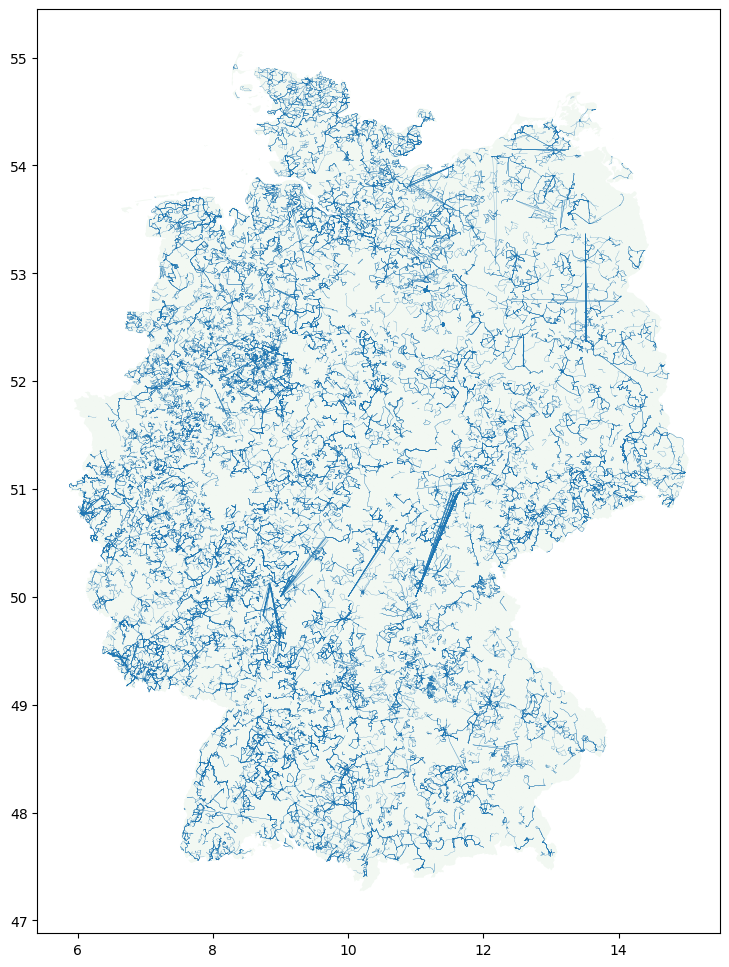

In [87]:
if manual:
    gpd.GeoDataFrame(circular).plot(linewidth=.15,
        ax=gpd.GeoDataFrame(sm.zones).plot(color='green', alpha=.05, figsize=(12,12)))

In [88]:
# Fix circular trips
# copy nodes that occur a second or third time in the trip and rename them
def fix_circular_duplicate(trip, sep='_dupl'):
    # Copy old node names into a seperate column
    trip['b_old'] = trip['b'].copy()
    # Get duplicate nodes
    dupl = trip.loc[trip['b'].duplicated(keep='first')].index
    count = 1
    for dupl_node in dupl:
        # rename the next occurence of this node
        trip.loc[dupl, 'b'] = trip.loc[dupl, 'b'] + sep + str(count)
        count += 1
    return trip

In [89]:
fixed = circular.reset_index(level='trip_id', drop=True).groupby('trip_id').apply(fix_circular_duplicate)
len(fixed)

388115

In [90]:
# Check that there are no circular lines anymore
fixed = fixed.reset_index(level='trip_id', drop=True)
still_circular = fixed.groupby('trip_id').apply(test_circular)
len(still_circular)

92406

In [91]:
if len(still_circular) > 0:
    fixed.drop(still_circular.reset_index(level='trip_id', drop=True).index, inplace=True)
len(fixed)

295709

In [95]:
# Rename duplicate nodes in the node table
dupl_nodes = fixed.loc[fixed['b'].str.contains('dupl')].set_index('b')['b_old']
nodes_copy = sm.nodes.loc[list(dupl_nodes)].copy()
assert len(dupl_nodes) == len(nodes_copy)
nodes_copy.index = dupl_nodes.index
sm.nodes = pd.concat([sm.nodes, nodes_copy])

In [97]:
# Replace circular lines with fixed trips
sm.links = sm.links.loc[~sm.links['trip_id'].isin(circular['trip_id'].unique())]
sm.links = pd.concat([sm.links, fixed[list(sm.links.columns)]])
len(sm.links)

1412058

In [110]:
# Drop duplicated nodes
sm.nodes = sm.nodes.loc[~sm.nodes.index.duplicated()]
len(sm.nodes)

136491

In [111]:
# Test node set integrity
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Number of orphan nodes: {}'.format(
        len(sm.orphan_nodes)))
    print('Number of missing nodes: {}'.format(
        len(sm.missing_nodes)))

no road_links or road_nodes


In [99]:
# Drop orphan nodes
sm.nodes.drop(sm.orphan_nodes, inplace=True)

In [ ]:
# Test sequences again
sm.links.groupby('trip_id').apply(test_sequences)

In [100]:
sm.links.drop(['disaggregated_a', 'disaggregated_b'], axis=1, inplace=True)
assert len(sm.links.loc[sm.links.isna().any(axis=1)]) == 0

In [101]:
# Add bus service to ancilliary
sm.agencies = pd.concat([sm.agencies, bus.agencies]).reset_index(drop=True)
sm.pt_routes = pd.concat([sm.pt_routes, bus.pt_routes]).reset_index(drop=True)

In [102]:
# Now, we have bus services in the same tables
sm.pt_route_types = list(sm.links['route_type'].unique())
sm.pt_route_types

['air', 'bus', 'coach', 'rail_long', 'rail_short']

In [103]:
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

,route_id,route_type,a,b,time,trip_id,link_sequence,headway,geometry,route_type_disagg
index,,,,,,,,,,
rs_27924,rs_246,rail_short,rs_92720149_0,rs_92720149_1,300.0,rs_246_0,1.0,43200.0,"LINESTRING (13.35926 48.91772, 13.33618 48.94470)",rail_short


## Save model


In [104]:
# Cast columns to integer
cols = ['link_sequence', 'time', 'headway']
sm.links[cols] = sm.links[cols].astype(int)

In [105]:
# Reduce nodes table size by dropping stop names
sm.nodes = sm.nodes[['FID', 'route_type', 'geometry']]
if np.issubdtype(sm.nodes['FID'].dtype, np.number):
    sm.nodes['FID'] = sm.nodes['FID'].astype(int)

In [106]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [112]:
# Saving model...
sm.to_json(model_path + scenario + '/' + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 19/19 [04:11<00:00, 13.25s/it]


In [113]:
sm.to_json(model_path + scenario + '/' + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes'],
           encoding='utf-8')

to_hdf(overwriting):   0%|                                                                      | 0/19 [00:00<?, ?it/s]C:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\geopandas\io\file.py:633: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)
to_hdf(overwriting): 100%|████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.80it/s]


In [114]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + scenario + '/' + 'de_pt_network_agg/links_quetzaldata.json')

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_16508\2672830926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auxiliary['index'] = auxiliary.index
